# ESPECIALIZACION EN BIG DATA - TRABAJO FINAL

## PACKAGES

In [327]:
import os
import datetime as dt
import sys
import warnings

from influxdb_client import InfluxDBClient

import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
from numpy.linalg import LinAlgError

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pylab import rcParams 

import itertools

from scipy import stats
from scipy.stats import probplot, moment

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf, q_stat, adfuller

import pmdarima as pm

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

In [328]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [329]:
################################################################# PARAMETERS ###############################################################
############################################################################################################################################

# INFLUXDB CLIENT
INFLUXDB_URL = os.getenv('INFLUXDB_URL')
INFLUXDB_TOKEN = os.getenv('INFLUXDB_TOKEN')
INFLUXDB_ORG = os.getenv('INFLUXDB_ORG')
INFLUXDB_TIMEOUT = 300000

# INFLUXDB READ/WRITE API
INFLUXDB_BUCKET = "coinmarketcapBucket"
INFLUXDB_MEASUREMENT = "dailyCandleSticks"

############################################################################################################################################
############################################################################################################################################

In [330]:
################################################################# FUNCTIONS ################################################################
############################################################################################################################################

def basic_query(bucket, measurement, start_date, stop_date):
    query = f''' 
      from(bucket: "{bucket}")
      |> range(start: {start_date}, stop: {stop_date})
      |> filter(fn: (r) => r["_measurement"] == "{measurement}")
      |> pivot(
        rowKey:["_time"],
        columnKey: ["_field"],
        valueColumn: "_value"
        )
      |> drop(columns: ["_start", "_stop","_measurement"])
    ''' 
    
    query = query + '  |> rename(columns: {_time: "datetime"})'
    
    return query

def query_influxdb(query, url, token, org, timeout, debug=False):
    
    '''
    returns pandas dataframe
    '''
    
    with InfluxDBClient(url=url, token=token, org=org, timeout=timeout, enable_gzip=True, debug=debug) as client:
    
        result_df = client.query_api().query_data_frame(org=org, query=query)
        result_df.drop(columns = ['result', 'table'], inplace = True)
    return result_df

def date_to_iso_date(date):
    '''
    date: str Date with format "%Y-%m-%d, eg. 1985-05-27
    returns: ISO 8601 date in string format
    '''
    timestamp = date + " 00:00:00"  

    isodate = dt.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S").replace(tzinfo=dt.timezone.utc)
    isodate = isodate.isoformat('T', 'microseconds')
    return isodate

def hurst(ts):
      """Returns the Hurst Exponent of the time series vector ts"""
      # Create the range of lag values
      lags = range(2, 100)
      
      # Calculate the array of the variances of the lagged differences
      tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
      
      # Use a linear fit to estimate the Hurst Exponent
      poly = polyfit(log(lags), log(tau), 1)
      
      # Return the Hurst exponent from the polyfit output
      return poly[0]*2.0   

def plot_correlogram(x, lags=None, title=None):    
      lags = min(10, int(len(x)/5)) if lags is None else lags
      fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
      x.plot(ax=axes[0][0])
      q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
      stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
      axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
      probplot(x, plot=axes[0][1])
      mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
      s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
      axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
      plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
      plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
      axes[1][0].set_xlabel('Lag')
      axes[1][1].set_xlabel('Lag')
      fig.suptitle(title, fontsize=20)
      fig.tight_layout()
      fig.subplots_adjust(top=.9)

############################################################################################################################################
############################################################################################################################################

## DATA PROCESSING

### RETRIEVAL

In [331]:
################################################################ DATA RETRIEVAL ############################################################
############################################################################################################################################

start_date = date_to_iso_date("2015-08-09")
stop_date = date_to_iso_date("2021-07-11")
query = basic_query(INFLUXDB_BUCKET, INFLUXDB_MEASUREMENT, start_date, stop_date)

eth_df = query_influxdb(query, INFLUXDB_URL, INFLUXDB_TOKEN, INFLUXDB_ORG, INFLUXDB_TIMEOUT)

############################################################################################################################################
############################################################################################################################################


In [332]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 0 to 2159
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   datetime   2160 non-null   datetime64[ns, UTC]
 1   symbol     2160 non-null   object             
 2   close      2160 non-null   float64            
 3   high       2160 non-null   float64            
 4   low        2160 non-null   float64            
 5   marketcap  2160 non-null   float64            
 6   open       2160 non-null   float64            
 7   volume     2160 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), object(1)
memory usage: 151.9+ KB


In [333]:
eth_df.head()

,datetime,symbol,close,high,low,marketcap,open,volume
0,2015-08-09 02:59:59+00:00,ETH,0.753325,2.798810,0.714725,4.548689e+07,2.793760,674188.0
1,2015-08-10 02:59:59+00:00,ETH,0.701897,0.879810,0.629191,4.239957e+07,0.706136,532170.0
2,2015-08-11 02:59:59+00:00,ETH,0.708448,0.729854,0.636546,4.281836e+07,0.713989,405283.0
3,2015-08-12 02:59:59+00:00,ETH,1.067860,1.131410,0.663235,6.456929e+07,0.708087,1463100.0
4,2015-08-13 02:59:59+00:00,ETH,1.217440,1.289940,0.883608,7.364501e+07,1.058750,2150620.0


In [387]:
eth_df.tail()

,symbol,close,high,low,marketcap,open,volume,gross_return,net_return,log_return,volatility
datetime,,,,,,,,,,,
2021-07-03 00:00:00+00:00,ETH,2150.040364,2155.596496,2021.824808,2.505527e+11,2109.892677,3.179621e+10,1.017238,0.017238,0.017091,0.000179
2021-07-04 00:00:00+00:00,ETH,2226.114282,2237.567155,2117.590013,2.594475e+11,2150.835025,1.743336e+10,1.035383,0.035383,0.034771,0.000964
2021-07-05 00:00:00+00:00,ETH,2321.724112,2384.286857,2190.837703,2.706217e+11,2226.550382,1.878711e+10,1.042949,0.042949,0.042052,0.001469
2021-07-06 00:00:00+00:00,ETH,2198.582464,2321.922836,2163.041394,2.562978e+11,2321.922836,2.010379e+10,0.946961,-0.053039,-0.054497,0.003389
2021-07-07 00:00:00+00:00,ETH,2324.679449,2346.294874,2197.919385,2.710286e+11,2197.919385,2.089186e+10,1.057354,0.057354,0.055769,0.002709


### PREPROCESSING

In [334]:
# datetime to date

eth_df['datetime'] = eth_df['datetime'].dt.normalize()

# cf. https://stackoverflow.com/questions/16176996/keep-only-date-part-when-using-pandas-to-datetime

# Simple gross return (cf. eq (1.1) from Tsay - Analysis of financial time series (2010))

eth_df['gross_return'] = eth_df['close'].div(eth_df['close'].shift(1))

# Simple net return (cf. eq (1.1) from Tsay - Analysis of financial time series (2010))

eth_df['net_return'] = eth_df['gross_return'] - 1

# Continuously compounded return or log-return (cf. eq (1.1) from Tsay)

eth_df['log_return'] = eth_df['gross_return'].apply(lambda row: np.log(row))

# Daily Volatility

eth_df['volatility'] = eth_df['log_return'].sub(eth_df['log_return'].mean()).pow(2) 

eth_df = eth_df.dropna()

eth_df.head()

,datetime,symbol,close,high,low,marketcap,open,volume,gross_return,net_return,log_return,volatility
1,2015-08-10 00:00:00+00:00,ETH,0.701897,0.879810,0.629191,4.239957e+07,0.706136,532170.0,0.931732,-0.068268,-0.070710,0.005540
2,2015-08-11 00:00:00+00:00,ETH,0.708448,0.729854,0.636546,4.281836e+07,0.713989,405283.0,1.009333,0.009333,0.009290,0.000031
3,2015-08-12 00:00:00+00:00,ETH,1.067860,1.131410,0.663235,6.456929e+07,0.708087,1463100.0,1.507323,0.507323,0.410335,0.165335
4,2015-08-13 00:00:00+00:00,ETH,1.217440,1.289940,0.883608,7.364501e+07,1.058750,2150620.0,1.140075,0.140075,0.131094,0.016224
5,2015-08-14 00:00:00+00:00,ETH,1.827670,1.965070,1.171990,1.106072e+08,1.222240,4068680.0,1.501240,0.501240,0.406292,0.162063


In [335]:
eth_df.set_index('datetime', inplace=True)

In [392]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2159 entries, 2015-08-10 00:00:00+00:00 to 2021-07-07 00:00:00+00:00
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   symbol        2159 non-null   object 
 1   close         2159 non-null   float64
 2   high          2159 non-null   float64
 3   low           2159 non-null   float64
 4   marketcap     2159 non-null   float64
 5   open          2159 non-null   float64
 6   volume        2159 non-null   float64
 7   gross_return  2159 non-null   float64
 8   net_return    2159 non-null   float64
 9   log_return    2159 non-null   float64
 10  volatility    2159 non-null   float64
dtypes: float64(10), object(1)
memory usage: 202.4+ KB


#### TRAIN - TEST SPLITTING

Usamos el 70% inicial de los datos para training y el restante 30% para testing

In [336]:
train_df, test_df = train_test_split(eth_df, test_size=0.3, shuffle=False)

# cf. https://stackoverflow.com/questions/50879915/splitting-data-using-time-based-splitting-in-test-and-train-datasets

In [337]:
train_df.head()

,symbol,close,high,low,marketcap,open,volume,gross_return,net_return,log_return,volatility
datetime,,,,,,,,,,,
2015-08-10 00:00:00+00:00,ETH,0.701897,0.879810,0.629191,4.239957e+07,0.706136,532170.0,0.931732,-0.068268,-0.070710,0.005540
2015-08-11 00:00:00+00:00,ETH,0.708448,0.729854,0.636546,4.281836e+07,0.713989,405283.0,1.009333,0.009333,0.009290,0.000031
2015-08-12 00:00:00+00:00,ETH,1.067860,1.131410,0.663235,6.456929e+07,0.708087,1463100.0,1.507323,0.507323,0.410335,0.165335
2015-08-13 00:00:00+00:00,ETH,1.217440,1.289940,0.883608,7.364501e+07,1.058750,2150620.0,1.140075,0.140075,0.131094,0.016224
2015-08-14 00:00:00+00:00,ETH,1.827670,1.965070,1.171990,1.106072e+08,1.222240,4068680.0,1.501240,0.501240,0.406292,0.162063


In [338]:
test_df.head()

,symbol,close,high,low,marketcap,open,volume,gross_return,net_return,log_return,volatility
datetime,,,,,,,,,,,
2019-09-29 00:00:00+00:00,ETH,174.572892,175.778730,170.773954,1.884231e+10,174.680833,6.895423e+09,0.999210,-0.000790,-0.000791,0.000020
2019-09-30 00:00:00+00:00,ETH,170.503485,175.210218,166.997689,1.840540e+10,174.612745,6.497088e+09,0.976689,-0.023311,-0.023587,0.000746
2019-10-01 00:00:00+00:00,ETH,179.872201,179.872201,167.036606,1.941915e+10,170.461353,7.552915e+09,1.054947,0.054947,0.053491,0.002477
2019-10-02 00:00:00+00:00,ETH,177.340420,185.045535,175.812653,1.914822e+10,180.209117,7.676276e+09,0.985925,-0.014075,-0.014175,0.000320
2019-10-03 00:00:00+00:00,ETH,180.710506,180.826122,175.334275,1.951452e+10,177.224053,6.335595e+09,1.019003,0.019003,0.018825,0.000228


## DATA ANALYSIS

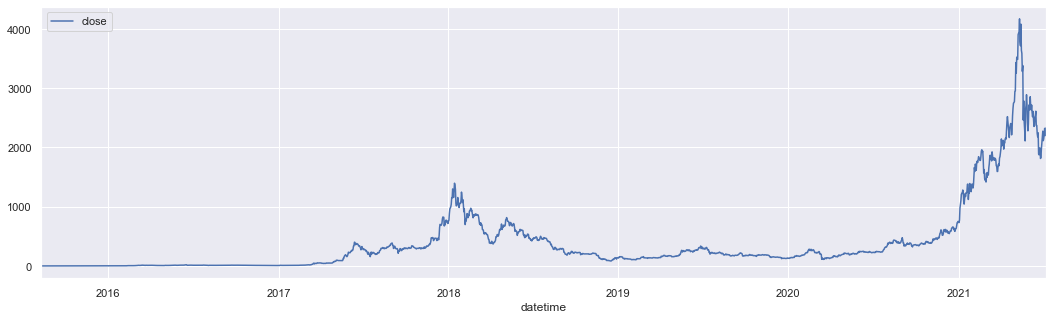

In [389]:
eth_df.plot(y=['close'], use_index=True)
# cf https://stackoverflow.com/questions/20084487/use-index-in-pandas-to-plot-data/20084590
plt.savefig('plots/ETH_close_price.png')
plt.show()

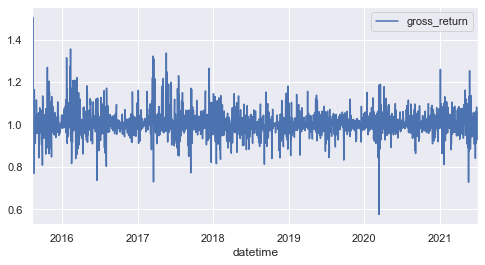

In [341]:
eth_df.plot(y=['gross_return'], use_index=True)
plt.show()

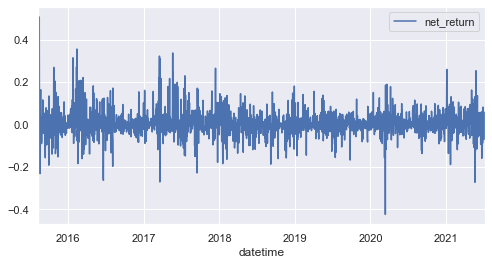

In [342]:
eth_df.plot(y=['net_return'], use_index=True)
plt.show()

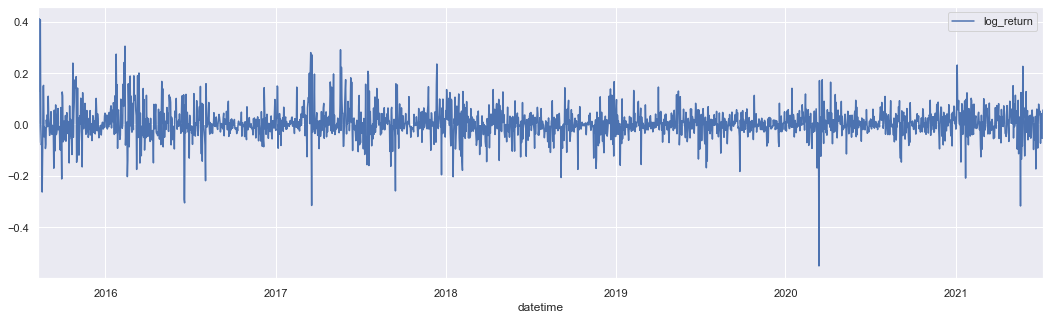

In [390]:
eth_df.plot(y=['log_return'], use_index=True)
plt.savefig('plots/ETH_log_return.png')
plt.show()

## DATA MODELLING
### MODELO SARIMA 

Seasonal Autoregressive Integrated Moving Average, SARIMA o Seasonal ARIMA, es una extensión del modelo ARIMA 
que soporta el manejo del comportamiento estacional de una serie emporal univariada.

A los parámetros (p, d, q) que especifican el orden de auto-regresión (AR), de diferenciación (I) y de moving 
average (MA) en el modelo ARIMA tradicional, el modelo SARIMA añade los parámetros (P, D, Q) que tratan de idéntica forma a la componente estacional de la serie, así como también un parámetro m que describe la longitud del período estacional, medido en unidades temporales de la propia serie.

Especificar un modelo SARIMA requiere consecuentemente seleccionar hiperparámetros tanto para la tendencia como para la componente estacional de la serie. Concretamente, para la tendencia, modelada por el modelo ARIMA queda

TENDENCIA

* p: int. Orden de auto regresión
* d: int. Orden de diferenciación
* q: int. Orden de moving average

COMPONENTE ESTACIONAL

* P: int. Orden de auto regresión
* D: int. Orden de diferenciación
* Q: int. Orden de moving average
* m: int. longitud del período estacional

Teniendo esto en cuenta, con estas definiciones denotamos un modelo SARIMA mediante

**SARIMA(p,d,q)(P,D,Q)m**

En particular, tenemos que 

**ARIMA(p,d,q) = SARIMA(p,d,q)(0,0,0)0**

y además

**ARMA(p,q) = ARIMA(p,0,q) = SARIMA(p,0,q)(0,0,0)0**



### MODEL FITTING

#### EXPLORACION DE ACF Y PACF

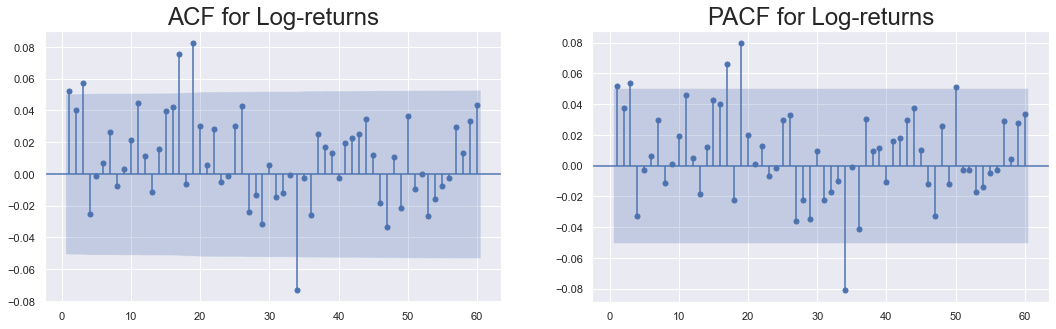

In [391]:
plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train_df['log_return'][1:], zero = False, lags = 60, ax = axes[0])
sgt.plot_pacf(train_df['log_return'][1:], zero = False, lags = 60, ax = axes[1])

axes[0].set_title("ACF for Log-returns", size = 24)
axes[1].set_title("PACF for Log-returns", size = 24)

plt.savefig('plots/ETH_ACF_PACF_log_return.png')

plt.show()

#### SELECCION DEL MEJOR MODELO

Seleccionaremos el modelo SARIMA(p,d,q)(0,0,0)0 en base al conjunto de hiperparametros que minimice el AIC. Para ello construimos la lista pdq

In [156]:
# we make three ranges (0,1) and store them in p, d, q respectively
p = d = q = range(0, 3) 
# we use itertools.product to make a cartesian product of p, d, q and then we store its results in a list called pdq
pdq = list(itertools.product(p, d, q))
# we do the same for the seasonal parameters, having set m = 7 (weekly seasonal period)
#seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

In [236]:
arima_parameters = []
AIC = []

for param in pdq:
    try:
        # SARIMAX MODEL INITIALIZATION
        sarimax = sm.tsa.statespace.SARIMAX(train_df['log_return'][1:],
                                        order=param)
        
        # SARIMAX MODEL FITTING
        fitted_sarimax = sarimax.fit(max_iter = 100, method = 'powell')
        
        arima_parameters.append(param)
        
        AIC.append(fitted_sarimax.aic)
        
        print('SARIMA{},(0,0,0) - AIC:{}'.format(param, np.round(fitted_sarimax.aic,2)))

    except:
        continue

# we obtain index for minimum AIC

min_AIC_index = AIC.index(min(AIC))

f'The optimum set of parameters for SARIMA model is [p,d,q]: {arima_parameters[min_AIC_index]}. For that choice we get an AIC index of {np.round(AIC[min_AIC_index],2)}'

Optimization terminated successfully.
         Current function value: -1.312631
         Iterations: 1
         Function evaluations: 25
SARIMA(0, 0, 0),(0,0,0) - AIC:-3962.15
Optimization terminated successfully.
         Current function value: -1.314039
         Iterations: 2
         Function evaluations: 58
SARIMA(0, 0, 1),(0,0,0) - AIC:-3964.4
Optimization terminated successfully.
         Current function value: -1.314763
         Iterations: 2
         Function evaluations: 77
SARIMA(0, 0, 2),(0,0,0) - AIC:-3964.59
Optimization terminated successfully.
         Current function value: -0.993460
         Iterations: 1
         Function evaluations: 19
SARIMA(0, 1, 0),(0,0,0) - AIC:-2998.25
Optimization terminated successfully.
         Current function value: -1.312139
         Iterations: 2
         Function evaluations: 73
SARIMA(0, 1, 1),(0,0,0) - AIC:-3958.66
Optimization terminated successfully.
         Current function value: -1.313001
         Iterations: 2
         Fun

'The optimum set of parameters for SARIMA model is [p,d,q]: (1, 0, 1). For that choice we get an AIC index of -3969.76'

#### DATA FITTING CON EL MEJOR MODELO

In [304]:
arma = sm.tsa.statespace.SARIMAX(train_df["log_return"][1:], order = (1, 0, 1))
arma_model = arma.fit(max_iter = 100, method = 'powell')
print(arma_model.summary())

Optimization terminated successfully.
         Current function value: -1.316478
         Iterations: 2
         Function evaluations: 93
                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 1510
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1987.881
Date:                Sun, 26 Dec 2021   AIC                          -3969.763
Time:                        19:45:58   BIC                          -3953.803
Sample:                    08-11-2015   HQIC                         -3963.819
                         - 09-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9850      0.011     89.224      0.000       0.963      

#### ARMA FORECAST SOBRE TEST DATA

In [305]:
arma_forecast = arma_model.get_forecast(len(test_df.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05) # Confidence level of 95%
arma_predictions_df["predicted log_return"] = arma_model.predict(start = test_df.index[0], end = test_df.index[-1])

In [306]:
arma_predictions_df.head()

,lower log_return,upper log_return,predicted log_return
2019-09-29 00:00:00+00:00,-0.128953,0.125117,-0.001918
2019-09-30 00:00:00+00:00,-0.128939,0.125161,-0.001889
2019-10-01 00:00:00+00:00,-0.128925,0.125204,-0.001861
2019-10-02 00:00:00+00:00,-0.128911,0.125246,-0.001833
2019-10-03 00:00:00+00:00,-0.128897,0.125287,-0.001805


#### PLOTEO DE FORECAST SOBRE TEST DATASET CON INTERVALOS DE CONFIANZA

In [317]:
arma_mse = mean_squared_error(test_df["log_return"].values, arma_predictions_df["predicted log_return"])

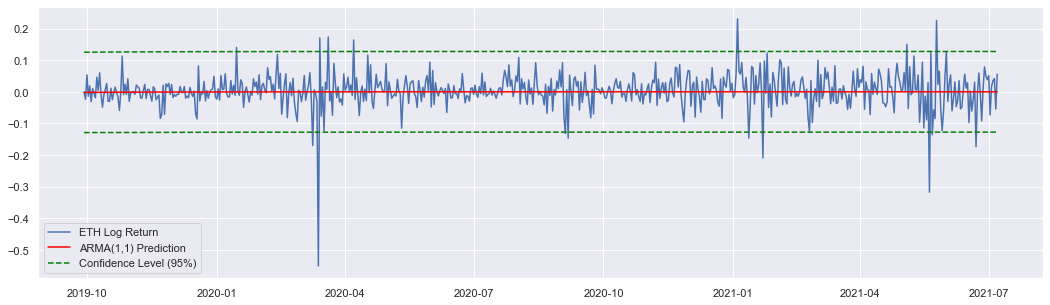

In [422]:

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["log_return"], label = "ETH Log Return")

plt.plot(arma_predictions_df["predicted log_return"], color = "red", label = "ARMA(1,1) Prediction")
plt.plot(arma_predictions_df["upper log_return"], color = "green", linestyle = "--", label = "Confidence Level (95%)")
plt.plot(arma_predictions_df["lower log_return"], color = "green", linestyle = "--")
#plt.title(f"Return and Predicted Log_return for ETH using an ARMA(1,1) model with MSE: {round(arma_mse, 4)}", size = 16)
plt.legend(loc="lower left")
plt.savefig('plots/ETH_ARMA_log_return_predictions.png')
plt.show()

### AJUSTE DE LOS INTERVALOS DE CONFIANZA USANDO GARCH SOBRE LOS RESIDUOS DEL ARMA

#### EXPLORACION DE LOS RESIDUOS

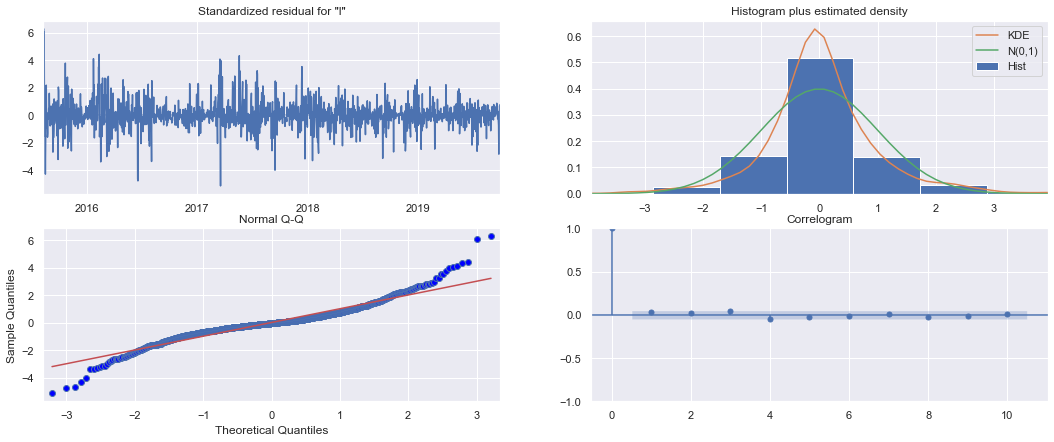

In [354]:
# Plot model residuals
arma_model.plot_diagnostics(figsize=(18, 7))
plt.show()

In [319]:
arma_model_residuals = arma_model.resid

In [320]:
print(arma_model_residuals)

datetime
2015-08-11 00:00:00+00:00    0.009290
2015-08-12 00:00:00+00:00    0.410123
2015-08-13 00:00:00+00:00    0.121734
2015-08-14 00:00:00+00:00    0.394413
2015-08-15 00:00:00+00:00   -0.020038
                               ...   
2019-09-24 00:00:00+00:00   -0.047355
2019-09-25 00:00:00+00:00   -0.183313
2019-09-26 00:00:00+00:00    0.019158
2019-09-27 00:00:00+00:00   -0.022266
2019-09-28 00:00:00+00:00    0.049490
Length: 1510, dtype: float64


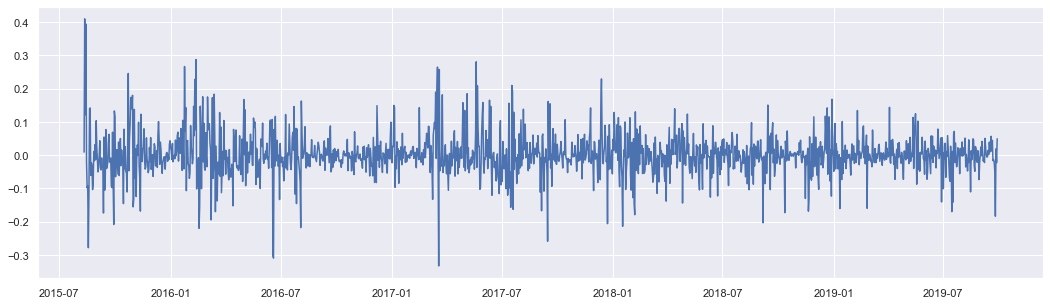

In [416]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(arma_model_residuals)
#plt.title("ARMA(1,1) Model residuals for ETH Returns", size = 24)
plt.savefig('plots/ETH_ARMA_log_return_residuals.png')
plt.show()

#### ANALISIS ACF Y PACF DE LOS RESIDUOS

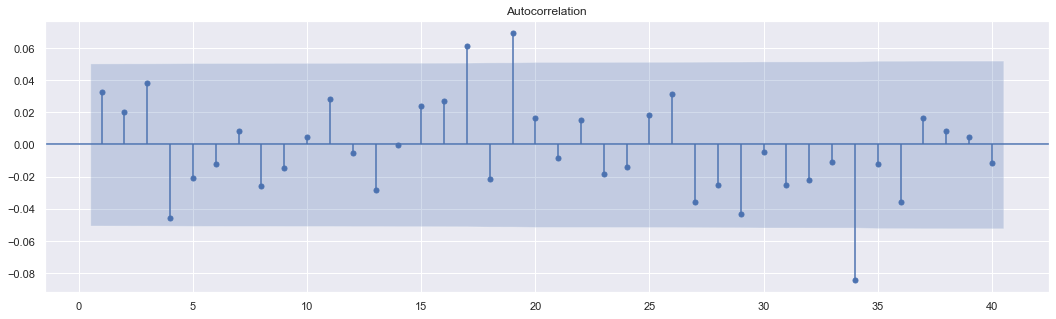

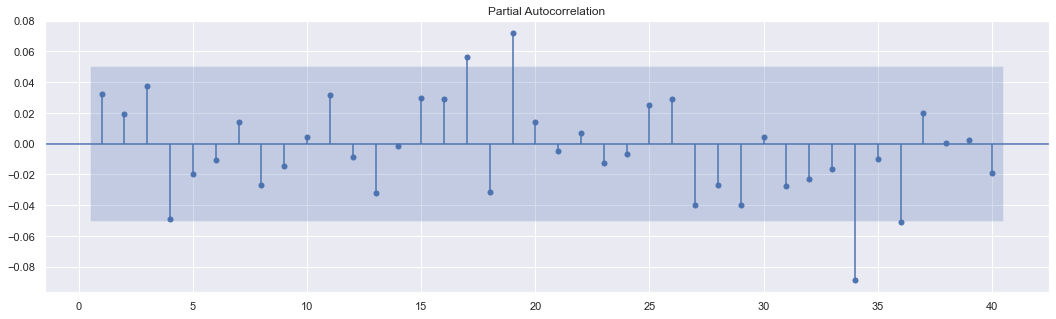

In [322]:
plt.rcParams["figure.figsize"] = 18, 5

sgt.plot_acf(arma_model_residuals, zero = False, lags = 40)
sgt.plot_pacf(arma_model_residuals, zero = False, lags = 40)

plt.show()

#### MODELADO DE LOS RESIDUOS DEL MODELO ARMA(1,1) USANDO UN MODELO DE TIPO GARCH

El objetivo en esta parte del trabajo es básicamente usar las volatilidades predichas por un modelo de tipo GARCH realizado sobre los residuos del ARMA(1,1) para corregir los intervalos de confianza planos que provee este último modelo.

In [323]:
resid_df = eth_df.copy()
resid_df["log_return_residue"] = resid_df["log_return"].shift(1).loc[resid_df.index]
resid_df.at[train_df.index[1]:train_df.index[-1], "log_return_residue"] = arma_model_residuals

In [326]:
resid_df.head(10)

,symbol,close,high,low,marketcap,open,volume,return,log_return,volatility,log_return_residue
datetime,,,,,,,,,,,
2015-08-10 00:00:00+00:00,ETH,0.701897,0.879810,0.629191,4.239957e+07,0.706136,532170.0,0.931732,-0.070710,0.005540,NaN
2015-08-11 00:00:00+00:00,ETH,0.708448,0.729854,0.636546,4.281836e+07,0.713989,405283.0,1.009333,0.009290,0.000031,0.009290
2015-08-12 00:00:00+00:00,ETH,1.067860,1.131410,0.663235,6.456929e+07,0.708087,1463100.0,1.507323,0.410335,0.165335,0.410123
2015-08-13 00:00:00+00:00,ETH,1.217440,1.289940,0.883608,7.364501e+07,1.058750,2150620.0,1.140075,0.131094,0.016224,0.121734
2015-08-14 00:00:00+00:00,ETH,1.827670,1.965070,1.171990,1.106072e+08,1.222240,4068680.0,1.501240,0.406292,0.162063,0.394413
2015-08-15 00:00:00+00:00,ETH,1.827870,2.261880,1.754750,1.106723e+08,1.810920,4637030.0,1.000109,0.000109,0.000013,-0.020038
2015-08-16 00:00:00+00:00,ETH,1.688900,1.877240,1.570980,1.023036e+08,1.802890,2554360.0,0.923972,-0.079074,0.006855,-0.098497
2015-08-17 00:00:00+00:00,ETH,1.566030,1.695240,1.089810,9.490101e+07,1.684350,3550790.0,0.927249,-0.075534,0.006281,-0.092631
2015-08-18 00:00:00+00:00,ETH,1.203610,1.581190,1.185340,8.729537e+07,1.581190,1942830.0,0.768574,-0.263218,0.071257,-0.278179


In [404]:
resid_model = arch_model(resid_df["log_return_residue"][1:], p = 1, q = 0,
                      mean = 'Zero', vol = 'GARCH', dist = 'skewt')
resid_model_results = resid_model.fit(last_obs = test_df.index[0], update_freq = 5)
# Fixed Window Forecasting
# cf. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#Fixed-Window-Forecasting
print(resid_model_results.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: -1210.2734819209368
Iteration:     10,   Func. Count:     62,   Neg. LLF: -2106.362617388204
Iteration:     15,   Func. Count:     89,   Neg. LLF: -2227.572442170561
Iteration:     20,   Func. Count:    114,   Neg. LLF: -2228.1989599766785
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2228.207476728574
            Iterations: 24
            Function evaluations: 133
            Gradient evaluations: 24
                              Zero Mean - ARCH Model Results                             
Dep. Variable:                log_return_residue   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.001
Vol Model:                                  ARCH   Log-Likelihood:                2228.21
Distribution:      Standardized Skew Student's t   AIC:                          -4448.41
Method:                       Maximum Likelih

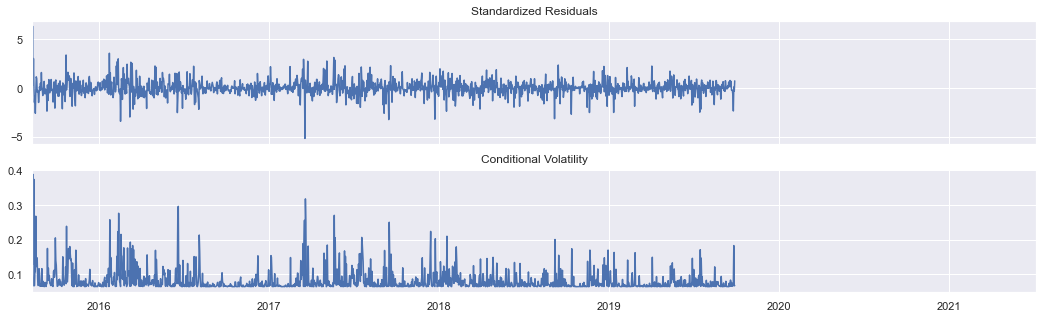

In [405]:
resid_model_results.plot()
plt.show()

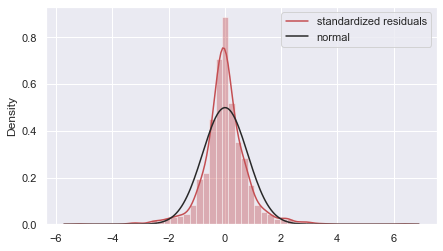

In [406]:
# Obtain model estimated residuals and volatility
garch_resid = resid_model_results.resid
garch_std = resid_model_results.conditional_volatility

# Calculate the standardized residuals
garch_std_resid = garch_resid/garch_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(garch_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('standardized residuals', 'normal'))
plt.show()

In [407]:
resid_variance_forecast = resid_model_results.forecast().residual_variance.loc[test_df.index].values
resid_volatility_forecast = np.sqrt(resid_variance_forecast)


In [408]:
# cambiamos los umbrales de confianza anteriores por la prediccion del ARMA(1,1) +/- prediccion del GARCH

arma_garch_predictions_df = arma_predictions_df.copy()
arma_garch_predictions_df["lower log_return"] = arma_garch_predictions_df["predicted log_return"] - resid_volatility_forecast.reshape(-1,)
arma_garch_predictions_df["upper log_return"] = arma_garch_predictions_df["predicted log_return"] + resid_volatility_forecast.reshape(-1,)

In [409]:
arma_garch_predictions_df.head()

,lower log_return,upper log_return,predicted log_return
2019-09-29 00:00:00+00:00,-0.079440,0.075604,-0.001918
2019-09-30 00:00:00+00:00,-0.065926,0.062147,-0.001889
2019-10-01 00:00:00+00:00,-0.069578,0.065857,-0.001861
2019-10-02 00:00:00+00:00,-0.083057,0.079392,-0.001833
2019-10-03 00:00:00+00:00,-0.067192,0.063582,-0.001805


In [410]:
# valores observados del log_return
test_df["log_return"]

datetime
2019-09-29 00:00:00+00:00   -0.000791
2019-09-30 00:00:00+00:00   -0.023587
2019-10-01 00:00:00+00:00    0.053491
2019-10-02 00:00:00+00:00   -0.014175
2019-10-03 00:00:00+00:00    0.018825
                               ...   
2021-07-03 00:00:00+00:00    0.017091
2021-07-04 00:00:00+00:00    0.034771
2021-07-05 00:00:00+00:00    0.042052
2021-07-06 00:00:00+00:00   -0.054497
2021-07-07 00:00:00+00:00    0.055769
Name: log_return, Length: 648, dtype: float64

[]

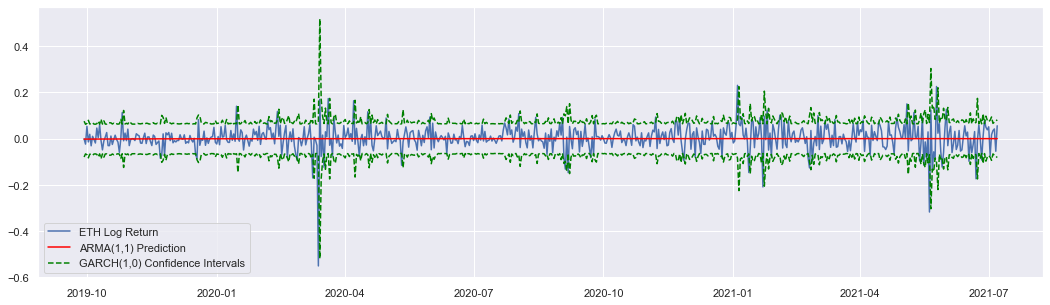

In [423]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["log_return"], label = "ETH Log Return")

plt.plot(arma_garch_predictions_df["predicted log_return"][test_df.index], color = "red", label = "ARMA(1,1) Prediction")

plt.plot(arma_garch_predictions_df["lower log_return"][test_df.index], color = "green", linestyle = "--", label = "GARCH(1,0) Confidence Intervals")
plt.plot(arma_garch_predictions_df["upper log_return"][test_df.index], color = "green", linestyle = "--")

plt.legend(loc="lower left")

plt.savefig('plots/ETH_ARMA_GARCH_log_return.png')

plt.plot()